## Eng+Wales well-mixed example model 

This is the inference notebook.  There are various model variants as encoded by `expt_params_local` and `model_local`, which are shared by the notebooks in a given directory.

Outputs of this notebook:
* `ewMod-inf.pik` : result of inference computation
* `ewMod-hess.npy` : hessian matrix of log-posterior

NOTE carefully : `Im` compartment is cumulative deaths, this is called `D` elsewhere

### Start notebook
(the following line is for efficient parallel processing)

In [1]:
%env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 
import pandas as pd
import matplotlib.image as mpimg
import pickle
import os
import pprint
import scipy.stats

In [3]:
# comment these before commit
#print(pyross.__file__)
#print(os.getcwd())

In [4]:
from ew_fns import *
import expt_params_local
import model_local

### switches etc

In [5]:
verboseMod=False    ## print ancillary info about the model? (would usually be False, for brevity)

## Calculate things, or load from files ?
doInf = False        ## do inference, or load it ?
doHes = False        ## Hessian may take a few minutes !! does this get removed? what to do?

## time unit is one week
daysPerWeek = 7.0

## these are params that might be varied in different expts
exptParams = expt_params_local.getLocalParams() 

pprint.pprint(exptParams)

## this is used for filename handling throughout
pikFileRoot = exptParams['pikFileRoot']

{'careFile': '../data/CareHomes.csv',
 'chooseCM': 'fumanelliEtAl',
 'dataFile': '../data/OnsData.csv',
 'estimatorTol': 1e-08,
 'exCare': True,
 'forecastTime': 3,
 'freeInitPriors': ['E', 'A', 'Is1', 'Is2', 'Is3'],
 'infOptions': {'cma_population': 32,
                'cma_processes': None,
                'ftol': 5e-05,
                'global_atol': 1.0,
                'global_max_iter': 1500,
                'local_max_iter': 400},
 'inferBetaNotAi': True,
 'numCohorts': 16,
 'numCohortsPopData': 19,
 'pikFileRoot': 'ewMod',
 'popFile': '../data/EWAgeDistributedNew.csv',
 'timeLast': 8,
 'timeZero': 0}


### convenient settings

In [6]:
np.set_printoptions(precision=3) 
pltAuto = True
plt.rcParams.update({'figure.autolayout': pltAuto})
plt.rcParams.update({'font.size': 14})

## LOAD MODEL

In [7]:
loadModel = model_local.loadModel(exptParams,daysPerWeek,verboseMod) 

## should use a dictionary but...
[ numCohorts, fi, N, Ni, model_spec, estimator, contactBasis, interventionFn,
   modParams, priorsAll, initPriorsLinMode, obsDeath, fltrDeath, 
   simTime, deathCumulativeDat ] = loadModel

** model

{'A': {'infection': [], 'linear': [['E', 'gammaE'], ['A', '-gammaA']]},
 'E': {'infection': [['A', 'beta'],
                     ['Is1', 'beta'],
                     ['Is2', 'betaLate'],
                     ['Is3', 'betaLate']],
       'linear': [['E', '-gammaE']]},
 'Im': {'infection': [], 'linear': [['Is3', 'cfr*gammaIs3']]},
 'Is1': {'infection': [],
         'linear': [['A', 'gammaA'],
                    ['Is1', '-alphabar*gammaIs1'],
                    ['Is1', '-alpha*gammaIs1']]},
 'Is2': {'infection': [],
         'linear': [['Is1', 'alphabar*gammaIs1'], ['Is2', '-gammaIs2']]},
 'Is3': {'infection': [],
         'linear': [['Is2', 'gammaIs2'],
                    ['Is3', '-cfrbar*gammaIs3'],
                    ['Is3', '-cfr*gammaIs3']]},
 'S': {'infection': [['A', '-beta'],
                     ['Is1', '-beta'],
                     ['Is2', '-betaLate'],
                     ['Is3', '-betaLate']],
       'linear': []},
 'classes': ['S', 'E', 'A', 'Is1', 'Is2', 'Is

### Inspect most likely trajectory for model with prior mean params

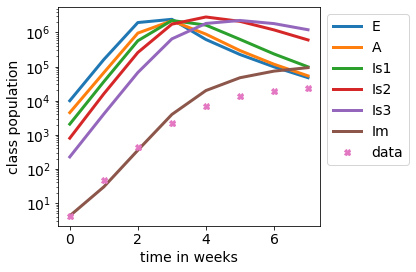

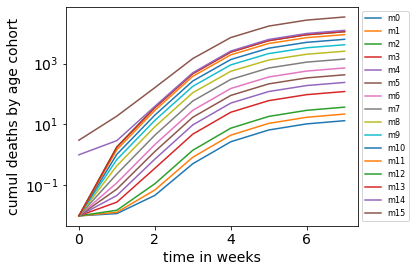

In [8]:
x0_lin = estimator.get_mean_inits(initPriorsLinMode, obsDeath[0], fltrDeath)
guessTraj = estimator.integrate( x0_lin, exptParams['timeZero'], simTime, simTime+1)

## plots

yesPlot = model_spec['classes'].copy()
yesPlot.remove('S')
plt.yscale('log')
for lab in yesPlot :
    indClass = model_spec['classes'].index(lab) 
    totClass = np.sum(guessTraj[:,indClass*numCohorts:(indClass+1)*numCohorts],axis=1)
    plt.plot( N * totClass,'-',lw=3,label=lab)
plt.plot(N*np.sum(obsDeath,axis=1),'X',label='data')
plt.legend(fontsize=14,bbox_to_anchor=(1, 1.0))
plt.xlabel('time in weeks')
plt.ylabel('class population')
plt.show() ; plt.close()

indClass = model_spec['classes'].index('Im')
plt.yscale('log')
for coh in range(numCohorts):
    plt.plot( N*guessTraj[:,coh+indClass*numCohorts],label='m{c:d}'.format(c=coh) )
plt.xlabel('time in weeks')
plt.ylabel('cumul deaths by age cohort')
plt.legend(fontsize=8,bbox_to_anchor=(1, 1.0))
plt.show() ; plt.close()

## INFERENCE

parameter count

* 32 for age-dependent Ai and Af (or beta and Af)
* 2 (step-like) or 3 (NPI-with-easing) for lockdown time and width (+easing param)
* 1 for projection of initial condition along mode
* 5 for initial condition in oldest cohort
* 5 for the gammas
* 1 for beta in late stage

total:  46 (step-like) or 47 (with-easing)

The following computation with CMA-ES takes some minutes depending on compute power, it should use multiple CPUs efficiently, if available.  The result will vary (slightly) according to the random seed, can be controlled by passing `cma_random_seed` to `latent_infer`

In [9]:
def runInf() : 

    infResult = estimator.latent_infer(obsDeath, fltrDeath, simTime, 
                                    priorsAll, 
                                    initPriorsLinMode, 
                                    generator=contactBasis, 
                                    intervention_fun=interventionFn, 
                                    tangent=False, 
                                    verbose=True, 
                                    enable_global=True,
                                    enable_local =True,
                                    **exptParams['infOptions'],
                                  )
    
    return infResult 

if doInf:
    ## do the computation
    elapsedInf = time.time() 

    infResult = runInf() 

    elapsedInf = time.time() - elapsedInf
    print('** elapsed time',elapsedInf/60.0,'mins')

    # save the answer
    opFile = pikFileRoot + "-inf.pik"
    print('opf',opFile)
    with open(opFile, 'wb') as f: 
        pickle.dump([infResult,elapsedInf],f)

else:
    ## load a saved computation
    print(' Load data')
    
# here we load the data 
# (this may be the file that we just saved, it is deliberately outside the if: else:)
ipFile = pikFileRoot + "-inf.pik"
print('ipf',ipFile)
with open(ipFile, 'rb') as f: 
    [infResult,elapsedInf] = pickle.load(f)

 Load data
ipf ewMod-inf.pik


#### unpack results

In [10]:
epiParamsMAP = infResult['params_dict']
conParamsMAP = infResult['control_params_dict']
x0_MAP = infResult['x0']

CM_MAP = contactBasis.intervention_custom_temporal( interventionFn, 
                                                    **conParamsMAP)

logPinf = -estimator.minus_logp_red(epiParamsMAP, x0_MAP, obsDeath, fltrDeath, simTime, 
                                    CM_MAP, tangent=False)
print('** measuredLikelihood',logPinf)
print('** logPosterior ',infResult['log_posterior'])
print('** logLikelihood',infResult['log_likelihood'])

** measuredLikelihood -256.28424763474663
** logPosterior  -170.0314499637275
** logLikelihood -256.28424763474663


#### MAP dominant trajectory

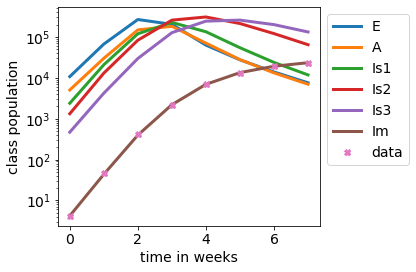

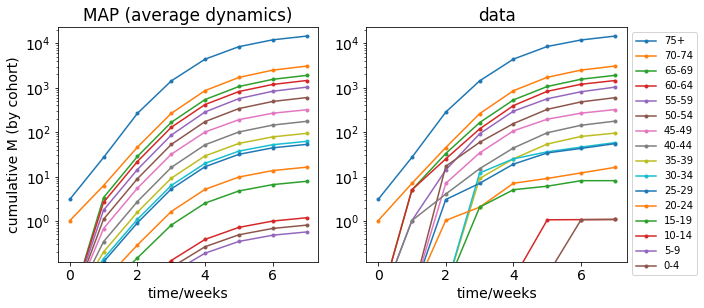

In [11]:
estimator.set_params(epiParamsMAP)
estimator.set_contact_matrix(CM_MAP)
trajMAP = estimator.integrate( x0_MAP, exptParams['timeZero'], simTime, simTime+1)

yesPlot = model_spec['classes'].copy()
yesPlot.remove('S')
plt.yscale('log')
for lab in yesPlot :
    indClass = model_spec['classes'].index(lab) 
    totClass = np.sum(trajMAP[:,indClass*numCohorts:(indClass+1)*numCohorts],axis=1)
    plt.plot( N * totClass,'-',lw=3,label=lab)
plt.plot(N*np.sum(obsDeath,axis=1),'X',label='data')
plt.xlabel('time in weeks')
plt.ylabel('class population')
plt.legend(fontsize=14,bbox_to_anchor=(1, 1.0))
plt.show() ; plt.close()

fig,axs = plt.subplots(1,2,figsize=(10,4.5))

cohRanges = [ [x,x+4] for x in range(0,75,5) ]
#print(cohRanges)
cohLabs = ["{l:d}-{u:d}".format(l=low,u=up) for [low,up] in cohRanges ]
cohLabs.append("75+")

ax = axs[0]
ax.set_title('MAP (average dynamics)')
mSize = 3
minY = 0.12
maxY = 1.0
indClass = model_spec['classes'].index('Im')
ax.set_yscale('log')
ax.set_ylabel('cumulative M (by cohort)')
ax.set_xlabel('time/weeks')
for coh in reversed(list(range(numCohorts))) :
    ax.plot( N*trajMAP[:,coh+indClass*numCohorts],'o-',label=cohLabs[coh],ms=mSize )
    maxY = np.maximum( maxY, np.max(N*trajMAP[:,coh+indClass*numCohorts]))
#ax.legend(fontsize=8,bbox_to_anchor=(1, 1.0))
maxY *= 1.6
ax.set_ylim(bottom=minY,top=maxY)
#plt.show() ; plt.close()

ax = axs[1]
ax.set_title('data')
ax.set_xlabel('time/weeks')
indClass = model_spec['classes'].index('Im')
ax.set_yscale('log')
for coh in reversed(list(range(numCohorts))) :
    ax.plot( N*obsDeath[:,coh],'o-',label=cohLabs[coh],ms=mSize )
## keep the same as other panel
ax.set_ylim(bottom=minY,top=maxY)

ax.legend(fontsize=10,bbox_to_anchor=(1, 1.0))
#plt.show() ; plt.close()
#plt.savefig('ageMAPandData.png')
plt.show(fig)

#### sanity check : plot the prior and inf value for one or two params

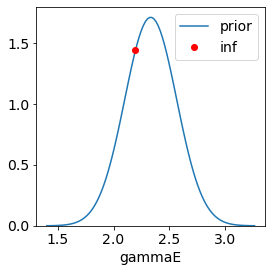

In [12]:
(likFun,priFun,dim) = pyross.evidence.latent_get_parameters(estimator,
                                    obsDeath, fltrDeath, simTime, 
                                    priorsAll, 
                                    initPriorsLinMode, 
                                    generator=contactBasis, 
                                    intervention_fun=interventionFn, 
                                    tangent=False, 
                                  )

def showInfPrior(xLab) :
    fig = plt.figure(figsize=(4,4))
    dimFlat = np.size(infResult['flat_params'])
    ## magic to work out the index of this param in flat_params
    jj = infResult['param_keys'].index(xLab)
    xInd = infResult['param_guess_range'][jj] 

    ## get the range
    xVals = np.linspace( *priorsAll[xLab]['bounds'], 100 )

    #print(infResult['flat_params'][xInd])
    pVals = []
    checkVals = []
    for xx in xVals :
        flatP = np.zeros( dimFlat )
        flatP[xInd] = xx
        pdfAll = np.exp( priFun.logpdf(flatP) )
        pVals.append( pdfAll[xInd] )
        #checkVals.append( scipy.stats.norm.pdf(xx,loc=0.2,scale=0.1) )

    plt.plot(xVals,pVals,'-',label='prior')
    infVal = infResult['flat_params'][xInd] 
    infPdf = np.exp( priFun.logpdf(infResult['flat_params']) )[xInd]
    plt.plot([infVal],[infPdf],'ro',label='inf')
    plt.xlabel(xLab)
    upperLim = 1.05*np.max(pVals)
    plt.ylim(0,upperLim)
    #plt.plot(xVals,checkVals)
    plt.legend()
    plt.show(fig) ; plt.close()

#print('**params\n',infResult['flat_params'])
#print('**logPrior\n',priFun.logpdf(infResult['flat_params']))
    
showInfPrior('gammaE')

## Hessian matrix of log-posterior
(this can take a few minutes, it does not make use of multiple cores)

In [13]:
if doHes:
    
    ## this eps amounts to a perturbation of approx 1% on each param
    ## (1/4) power of machine epsilon is standard for second deriv
    xx = infResult['flat_params']
    eps = 100 * xx*( np.spacing(xx)/xx )**(0.25) 
    
    #print('**params\n',infResult['flat_params'])
    #print('** rel eps\n',eps/infResult['flat_params']) 
    
    CM_MAP = contactBasis.intervention_custom_temporal( interventionFn, 
                                                        **conParamsMAP)
    estimator.set_params(epiParamsMAP)
    estimator.set_contact_matrix(CM_MAP)
        
    start = time.time()
    hessian = estimator.latent_hessian(obs=obsDeath, fltr=fltrDeath,
                Tf=simTime, generator=contactBasis, 
                infer_result=infResult, 
                intervention_fun=interventionFn,
                eps=eps, tangent=False, fd_method="central",
                inter_steps=0)
    end = time.time()
    print('time',(end-start)/60,'mins')
    
    opFile = pikFileRoot + "-hess.npy"
    print('opf',opFile)
    with open(opFile, 'wb') as f: 
        np.save(f,hessian)

else : 
    print('Load hessian')

# reload in all cases (even if we just saved it)
ipFile = pikFileRoot + "-hess.npy"
try:
    print('ipf',ipFile)
    with open(ipFile, 'rb') as f: 
        hessian = np.load(f)
except (OSError, IOError) : 
    print('... error loading hessian')
    hessian = None
    

Load hessian
ipf ewMod-hess.npy


In [14]:
#print(hessian)
print("** param vals")
print(infResult['flat_params'],'\n')
if np.all(hessian) != None : 
    print("** naive uncertainty v1 : reciprocal sqrt diagonal elements (x2)")
    print( 2/np.sqrt(np.diagonal(hessian)) ,'\n')
    print("** naive uncertainty v2 : sqrt diagonal elements of inverse (x2)")
    print( 2*np.sqrt(np.diagonal(np.linalg.inv(hessian))) ,'\n')

** param vals
[1.456e-01 7.827e-02 9.602e-02 2.483e-01 3.056e-01 6.848e-01 5.831e-01
 4.843e-01 5.065e-01 6.990e-01 8.370e-01 9.175e-01 1.027e+00 1.263e+00
 1.717e+00 2.964e+00 1.023e-01 2.197e+00 2.994e+00 2.424e+00 9.819e-01
 9.431e-01 1.525e-01 1.393e-01 1.443e-01 1.321e-01 1.495e-01 1.563e-01
 1.221e-01 1.675e-01 2.480e-01 1.376e-01 2.964e-01 3.646e-01 2.839e-01
 2.936e-01 3.273e-01 2.434e-01 2.229e+00 1.880e+00 5.993e-04 6.219e-05
 3.223e-05 4.121e-06 7.879e-07 5.468e-07] 

** naive uncertainty v1 : reciprocal sqrt diagonal elements (x2)
[9.170e-02 6.407e-02 5.779e-02 3.345e-02 3.670e-02 4.787e-02 5.419e-02
 3.843e-02 2.871e-02 3.549e-02 3.898e-02 3.452e-02 3.502e-02 4.634e-02
 5.365e-02 4.246e-02 1.053e-02 2.056e-02 6.508e-02 4.623e-02 3.704e-02
 3.497e-02 1.466e-01 1.301e-01 1.366e-01 1.151e-01 1.273e-01 1.040e-01
 9.056e-02 1.065e-01 9.249e-02 6.692e-02 6.319e-02 4.921e-02 4.168e-02
 4.042e-02 3.372e-02 1.316e-02 9.227e-03 8.659e-02 1.304e-05 8.071e-06
 4.691e-06 3.418e-06 7.73